<a href="https://colab.research.google.com/github/francoisdoanp/rotten-tomatoes-dataset/blob/master/Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MATH60121 - ROTTEN TOMATOES PROJECT**

---


The goal of this project explore two aspects of text mining: sentiment analysis and text summarization. To do so, we will use the context of Rotten Tomatoes, a popular movie review aggregation website. The user is presented short summaries of reviews by various critics, and a score is assigned: rotten or fresh.

As such, our project will be divided in two parts. The first part is to train a model to accurately predict if a movie is fresh or rotten based on the short summary. For this task, we will use Nicolas Gervais' rotten tomatoes dataset, available [here](https://https://github.com/francoisdoanp/rotten-tomatoes-dataset).

In the second part, we will attempt to summarize movie reviews from the Rolling Stone magazine, which rates its movies on 5 stars. Finally, we will use our model to predict whether our summary indicates a fresh or rotten score, which we can verify based on the stars. If our summarization is pertinent, then it should indicate whether the critic's sentiment towards that movie.




# Part 1: Sentiment Analysis

---



In [0]:
# Importing libraries

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output

from nltk.corpus import stopwords
import re


import networkx as nx
from scipy import sparse


In [27]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [0]:
# Uploading Dataset

url_base = 'https://raw.githubusercontent.com/francoisdoanp/rotten-tomatoes-dataset/master/small_rotten.txt'

rotten_db = pd.read_csv(url_base)

### Exploratory analysis

In [0]:
# Structure of the dataset

print(rotten_db.head)

# Examples of Fresh and Rotten movie reviews
print('Fresh review:', rotten_db['Review'][1])
print('Rotten review:', rotten_db['Review'][0])

<bound method NDFrame.head of         Freshness                                             Review
0               1  Manakamana doesn't answer any questions, yet m...
1               1  Wilfully offensive and powered by a chest-thum...
2               0  It would be difficult to imagine material more...
3               0  Despite the gusto its star brings to the role,...
4               0  If there was a good idea at the core of this f...
...           ...                                                ...
158395          0  Sean Anders' witless, embarrassingly puerile s...
158396          0  "The Water Diviner" just wants to tell an old-...
158397          0  Whatever most of the filmmakers here were tryi...
158398          1  You can't help but empathize with the people y...
158399          1  works in its own right as a semi-campy gloss o...

[158400 rows x 2 columns]>
Fresh review: Wilfully offensive and powered by a chest-thumping machismo, but it's good clean fun.
Rotten review:

1    79326
0    79074
Name: Freshness, dtype: int64


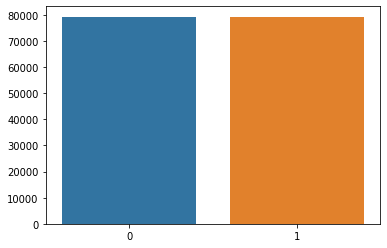

In [0]:
# Distribution of fresh vs rotten

dist = rotten_db['Freshness'].value_counts()
print(dist)
sns.barplot(dist.index, dist.values)

### Preprocessing

In [0]:
# Removing end of sentences' full content available message

test_c = "Decent enough as an action pic but sorely needing some Schwarzenegger ""magic."" (Full Content Review for Parents also available)"
test2_c = "Aside from a few jokes and some puns related to birds and the eventual invading pig population, this is a pretty lame exercise. (Full Content Review for Parents - Violence, Sexual Content, etc. - Also Available)"
test3_c = "While fans of the original work might get into this filmed adaptation, I came in cold and left even chillier in terms of appreciating what the movie was trying to be and how all of that was executed. (Full Content Review for Pare"

res_c = re.sub(r'\(Full Content.*$', " ", test3_c)

print("Original Sentence:", test3_c, "\nModified Sentence:", res_c)


Original Sentence: While fans of the original work might get into this filmed adaptation, I came in cold and left even chillier in terms of appreciating what the movie was trying to be and how all of that was executed. (Full Content Review for Pare 
Modified Sentence: While fans of the original work might get into this filmed adaptation, I came in cold and left even chillier in terms of appreciating what the movie was trying to be and how all of that was executed.  


In [0]:
# Removing end of sentences' Spanish translation Notice

test_s = "Thor: Ragnarock is a party and everyone is invited. [Full Review in Spanish]"

res_s = re.sub(r'\[Full Re.*$', " ", test_s)

print("Original Sentence:", test_s, "\nModified Sentence:", res_s)

Original Sentence: Thor: Ragnarock is a party and everyone is invited. [Full Review in Spanish] 
Modified Sentence: Thor: Ragnarock is a party and everyone is invited.  


In [0]:
# Removing video format notice

test_f = "[VIDEO ESSAY] ""Wild"" is an unsatisfying self-help drama that exposes the limitations of Reece Witherspoon's range."
test2_f = "[VIDEO] There's nothing flashy about David Gelb's serviceable rendering of a man who has achieved an unrivaled mastery of a cuisine he helped invent. You too might come away from the movie dreaming of Jiro Ono's sushi."

res_f = re.sub(r'\[VID.*\]', "", test2_f)

print("Original Sentence:", test_f, "\nModified Sentence:", res_f)

Original Sentence: [VIDEO ESSAY] Wild is an unsatisfying self-help drama that exposes the limitations of Reece Witherspoon's range. 
Modified Sentence:  There's nothing flashy about David Gelb's serviceable rendering of a man who has achieved an unrivaled mastery of a cuisine he helped invent. You too might come away from the movie dreaming of Jiro Ono's sushi.


In [0]:
# Separating in features and labels

reviews = rotten_db['Review'].values
labels = rotten_db['Freshness'].values

# Preparing test reviews 

test1 = reviews[5]
test2 = reviews[6]
test3 = reviews[7]
test4 = reviews[11]
test5 = reviews[13]

processed_reviews = []

for rev in range(0, len(reviews)):

  # Removing special instances as demonstrated previousy
  processed_review = re.sub(r'\(Full Content.*$', " ", str(reviews[rev]))
  processed_review = re.sub(r'\[Full Re.*$', " ", processed_review)
  processed_review = re.sub(r'\[VID.*\]', "", processed_review)

  # Removing special characters
  processed_review = re.sub(r'\W', ' ', processed_review)

  # Removing single characters
  processed_review = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_review)
  processed_review = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_review)

  # Removing multiple spaces
  processed_review = re.sub(r'\s+', ' ', processed_review, flags=re.I)
  processed_review = re.sub(r'\^\s+', '', processed_review, flags=re.I)

  # Transform reviews to lower case
  processed_review = processed_review.lower()

  processed_reviews.append(processed_review)

In [0]:
print("Original Sentence:", reviews[5], "\nModified Sentence:", processed_reviews[5], "\n\nOriginal Sentence:", reviews[6], "\nModified Sentence:", processed_reviews[6],
      "\n\nOriginal Sentence:", reviews[7], "\nModified Sentence:", processed_reviews[7], "\n\nOriginal Sentence:", reviews[11], "\nModified Sentence:", processed_reviews[11],
      "\n\nOriginal Sentence:", reviews[13], "\nModified Sentence:", processed_reviews[13])

Original Sentence: Gleeson goes the Hallmark Channel route, damaging an intermittently curious entry in the time travel subgenre. 
Modified Sentence: gleeson goes the hallmark channel route damaging an intermittently curious entry in the time travel subgenre  

Original Sentence: It was the height of satire in 1976: dark as hell, but patently absurd and surely nowhere close to objective reality. Objective reality surpassed it somewhere in the Jerry Springer era. 
Modified Sentence: it was the height of satire in 1976 dark as hell but patently absurd and surely nowhere close to objective reality objective reality surpassed it somewhere in the jerry springer era  

Original Sentence: Everyone in "The Comedian" deserves a better movie than "The Comedian." 
Modified Sentence: everyone in the comedian deserves better movie than the comedian  

Original Sentence: ... except for its shamelessly (and irresistibly) zingy music score (by the director), Halloween achieves its considerable power a

In [0]:
# Creating list of reviews

X = list(rotten_db['Review'])
Y = np.array(list(rotten_db['Freshness']))

for i in range(1, 10):
    print(X[i], '\n' , Y[i])


Wilfully offensive and powered by a chest-thumping machismo, but it's good clean fun. 
 1
It would be difficult to imagine material more wrong for Spade than Lost & Found. 
 0
Despite the gusto its star brings to the role, it's hard to ride shotgun on Hector's voyage of discovery. 
 0
If there was a good idea at the core of this film, it's been buried in an unsightly pile of flatulence jokes, dog-related bad puns and a ridiculous serial arson plot. 
 0
Gleeson goes the Hallmark Channel route, damaging an intermittently curious entry in the time travel subgenre. 
 0
It was the height of satire in 1976: dark as hell, but patently absurd and surely nowhere close to objective reality. Objective reality surpassed it somewhere in the Jerry Springer era. 
 1
Everyone in "The Comedian" deserves a better movie than "The Comedian." 
 0
Actor encourages grumpy Christians to embrace the season. 
 0
Slight, contained, but ineffably soulful. 
 1


#Part 2 : Test d'un premier modèle

In [0]:
rotten_db['Review'] = processed_reviews

# test
print(processed_reviews[5], "\n", rotten_db['Review'][5])

# Splitting the dataset into train and test set
train, test = train_test_split(rotten_db,test_size = 0.1)

gleeson goes the hallmark channel route damaging an intermittently curious entry in the time travel subgenre  
 gleeson goes the hallmark channel route damaging an intermittently curious entry in the time travel subgenre 


Positive words


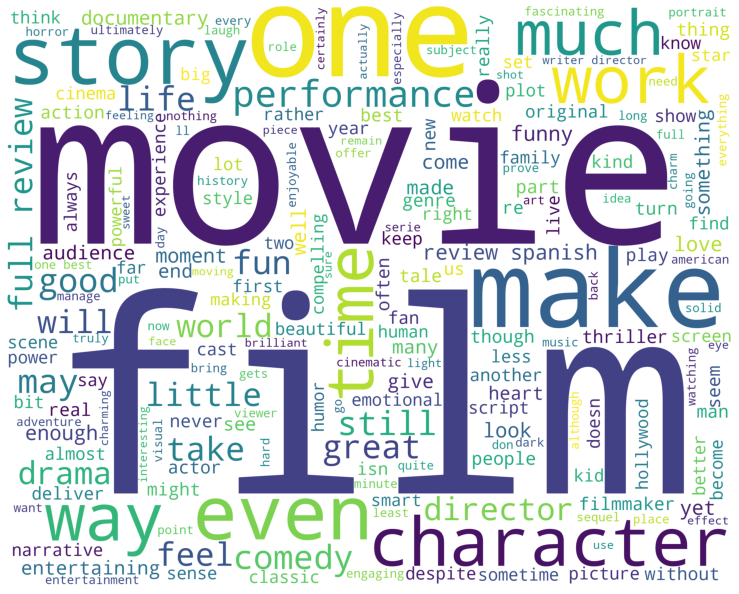

Negative words


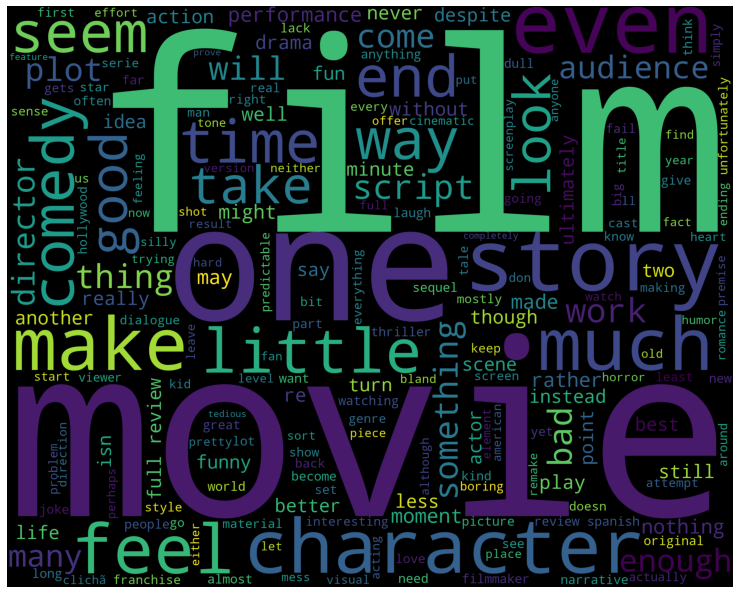

In [0]:
train_pos = train[ train['Freshness'] == 1]
train_pos = train_pos['Review']
train_neg = train[ train['Freshness'] == 0]
train_neg = train_neg['Review']

test_pos = test[ test['Freshness'] == 1]
test_pos = test_pos['Review']
test_neg = test[ test['Freshness'] == 0]
test_neg = test_neg['Review']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

Les mots "Film" et "Movie seraient clairement à retirer, ainsi que d'autres stopwords.
Mais on peut essayer de se servir uniquement des adjectifs

In [0]:
files_pos = rotten_db[ rotten_db['Freshness'] == 1]
files_neg = rotten_db[ rotten_db['Freshness'] == 0]

files_pos = files_pos[:50000]
files_neg = files_neg[:50000]

all_words = []
documents = []

stop_words = list(set(stopwords.words('english')))

#  j is adject, r is adverb, and v is verb
# allowed_word_types = ["J","R","V"]
allowed_word_types = ["J"]

for p in  files_pos['Review']:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    documents.append( (p, "Freshness") )
    
    # remove punctuations
    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p)
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    pos = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())
   
for p in files_neg['Review']:
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    documents.append( (p, "neg") )
    
    # remove punctuations
    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p)
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    neg = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in neg:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [0]:
len(all_words)

266808

In [0]:
# creating a frequency distribution of each adjectives.
all_words = nltk.FreqDist(all_words)

# listing the 5000 most frequent words
word_features = list(all_words.keys())[:5000]

# function to create a dictionary of features for each review in the list document.
# The keys are the words in word_features 
# The values of each key are either true or false for wether that feature appears in the review or not

def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

# Creating features for each review
featuresets = [(find_features(rev), category) for (rev, category) in documents]

# Splitting the dataset into train and test set
training_set, testing_set = train_test_split(featuresets,test_size = 0.4)

In [0]:
len(training_set)

In [0]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

classifier.show_most_informative_features(15)

### Part 2: Full review summarization

Five reviews have taken from Rolling Stone's website. Our goal is to output Rotten Tomatoes-style summaries.


In [28]:
# Importing full reviews

url_reviews = 'https://raw.githubusercontent.com/francoisdoanp/rotten-tomatoes-dataset/master/full-reviews.csv'

full_reviews = pd.read_csv(url_reviews)

print(full_reviews['review'][0])

The last time Universal tried to reinvent its classic monster series, it came up with 2017’s The Mummy, starring Tom Cruise, who probably wished his face was covered in bandages to disguise his participation. But hold off on the doomsaying regarding the studio’s “Dark Universe” reboot. Leigh Whannell’s The Invisible Man is a chilling mind-bender that strikes at our deepest fears — the ones we can’t see. The Australian writer-director co-created the Saw and Insidious franchises with James Wan; proved he had real directing chops with 2018’s Upgrade, a futuristic action thriller that went beyond the call of genre duty. He doesn’t resort to torture porn to update the famous H.G. Wells tale of a power-mad scientist who invents an invisibility cloak. Whannell and Co. are after way-scarier shit — namely, toxic masculinity. In tandem with horror maestro Jason Blum of Blumhouse (Get Out, Split, Paranormal Activity), Whannell revamps the story by flipping its focus. He gives a woman in peril all

In [29]:
# Splitting the full review into sentences

review_sent = []

for i in full_reviews['review']:
  review_sent.append(sent_tokenize(i))

print(review_sent)


[['The last time Universal tried to reinvent its classic monster series, it came up with 2017’s\xa0The Mummy,\xa0starring Tom Cruise, who probably wished his face was covered in bandages to disguise his participation.', 'But hold off on the doomsaying regarding the studio’s “Dark Universe” reboot.', 'Leigh Whannell’s\xa0The Invisible Man\xa0is a chilling mind-bender that strikes at our deepest fears — the ones we can’t see.', 'The Australian writer-director co-created the\xa0Saw\xa0and\xa0Insidious\xa0franchises with James Wan; proved he had real directing chops with\xa02018’s\xa0Upgrade,\xa0a futuristic action thriller that went beyond the call of genre duty.', 'He doesn’t resort to torture porn to update the famous H.G.', 'Wells tale of a power-mad scientist who invents an invisibility cloak.', 'Whannell and Co. are after way-scarier shit — namely, toxic masculinity.', 'In tandem with horror maestro Jason Blum of Blumhouse (Get Out, Split, Paranormal Activity), Whannell revamps the s

In [0]:
# Preprocessing on reviews

processed_full_reviews = []

for rev in review_sent:

  process_rev = []

  for sent in rev:
    # Removing single characters
    sent = re.sub(r'\W', ' ', sent) 
    sent = re.sub(r'\s+[a-zA-Z]\s+', ' ', sent)
    sent = re.sub(r'\^[a-zA-Z]\s+', ' ', sent)
    
    # Removing multiple spaces
    sent = re.sub(r' +', ' ', sent)

    # To lowercase
    sent = sent.lower()

    process_rev.append(sent)

  processed_full_reviews.append(process_rev)

In [0]:
# Removing stopwords

sw = set(stopwords.words('english'))

filtered_reviews = []

for review in processed_full_reviews:
    wr=[]
    for sent in review:

      sen_tokens = word_tokenize(sent)
      tokens_wo_sw = [word for word in sen_tokens if not word in sw]

      wr.append((" ").join(tokens_wo_sw))

    filtered_reviews.append(wr)

In [0]:
# Using TF-IDF Vectorizer

TFIDF_corpus = []

for reviews in filtered_reviews:
    tfidf = TfidfVectorizer()

    tfidf_rev = tfidf.fit_transform(reviews)
    
    TFIDF_corpus.append(tfidf_rev)

In [49]:
print(TFIDF_corpus[0].todense().shape)

(36, 373)


In [57]:
  sparse_matrix = sparse.csr_matrix(TFIDF_corpus[0])

  similarity_sparse = cosine_similarity(sparse_matrix, dense_output=True)

  similarity_sparse.shape

(36, 36)

In [0]:
# Creating function that takes as input a vector representation of a review, a full review and number of sentences
# for summarization. Outputs the top n sentences.

def summarize(mat, review, nsentence):

  # Creating similarity matrix

  sparse_matrix = sparse.csr_matrix(mat)

  similarity_sparse = cosine_similarity(sparse_matrix, dense_output=True)

  nx_graph = nx.from_numpy_array(similarity_sparse)
  best = nx.pagerank(nx_graph)

  top_sentences = sorted(((best[i], s) for i, s in enumerate(review)), reverse=True)

  for i in range(nsentence):
    print(top_sentences[i][1])



In [78]:
summarize(TFIDF_corpus[1], review_sent[1], 1)

If crimes against cinema merited prosecution, Blumhouse’s Fantasy Island would go directly to death row.
